In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
from openai import OpenAI

from src.embedding_model import embed
from src.utils import populate_everything, return_paragraphs_with_highest_score

In [65]:
question = """Hvor mye omtales smidig organisering og smidige prosjekter?"""
model = "gpt-4-turbo"
examples_to_retrieve = 10

In [66]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [67]:
completion = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "system",
            "content": "Jeg har en embedding-database med tekster fra offentlige dokumenter, og brukeren stiller spørsmål om tekstene i databasen. Gitt brukerens spørsmål, lag fem referansetekster som kan brukes som kan embeddes og sammenlignes med embeddingene i databasen med cosine-likhet for å finne tekster som kan brukes for å svare på brukerens spørsmål. Tekstene du lager skal være av varierende lengde slik at det fanger opp stikkordet som sees etter, i tillegg til noen lengre tekster som reflekterer ordlyden i tekstene som kan hjelpe å besvare spørsmålene. Pass på at tekstene er relativt ulike hverandre, slik at man kan ta gjennomsnittet av embeddingene for å fange opp essensen. Referansetekstene du lager skal ikke svare på spørsmålet til brukeren, men brukes for å finne tekster i databasen som ligner på tekster som kan besvare brukeren. Svaret ditt skal kun være en python liste, uten forklarende tekst",
        },
        {
            "role": "user",
            "content": f"{question}",
        },
    ],
)
print(completion.choices[0].message)

ChatCompletionMessage(content='[\n    "Smidig organisering og effektiviteten i prosjektutførelse",\n    "Implementering av smidige prosjektmetoder i offentlige virksomheter",\n    "Rapporter som diskuterer overgangen til smidige arbeidsmetoder i prosjektstyring",\n    "Forekomsten av smidige prinsipper og metodikker i prosjektledelse",\n    "Analyse av smidig praksis og dets innvirkning på prosjektresultater i offentlig sektor"\n]', role='assistant', function_call=None, tool_calls=None)


In [69]:
inn_texts = eval(completion.choices[0].message.content)

In [70]:
inn_texts

['Smidig organisering og effektiviteten i prosjektutførelse',
 'Implementering av smidige prosjektmetoder i offentlige virksomheter',
 'Rapporter som diskuterer overgangen til smidige arbeidsmetoder i prosjektstyring',
 'Forekomsten av smidige prinsipper og metodikker i prosjektledelse',
 'Analyse av smidig praksis og dets innvirkning på prosjektresultater i offentlig sektor']

In [71]:
inn_texts_embeddings = [embed(inn_text) for inn_text in inn_texts]
inn_texts_embeddings = np.array(inn_texts_embeddings)
inn_texts_embedding = np.mean(inn_texts_embeddings, axis=0)

In [72]:
df: pd.DataFrame = pd.read_pickle("df_with_embeddings_float32_filtered50.pkl")

In [73]:
populate_everything(df, inn_texts_embedding)

In [74]:
print(return_paragraphs_with_highest_score(
    df, "deviation_scaled_with_length", 1000))

Virksomhet: ARKIVVERKET
Dokument: Årsrapport Arkivverket 2022
Score: 1.000
tekstsnutt: Arkivverkets samfunnsoppdrag og hovedmål gis i statsbudsjettet og tildelingsbrevet, og
ligger til grunn for virksomhetsstrategien. Områdene gjør sine prioriteringer, både rundt drifts­
aktiviteter og utviklingsoppgaver. Viktige avgjørelser løftes opp til i toppledergruppen. Målinger
og rapporteringer fra driftsaktivitetene samles i Arkivverkets databank, mens utviklings­
aktivitetene har sin egen oppfølging gjennom porteføljeforvaltningen. Her tas det i bruk vanlige
prosjektstyrings- og porteføljestyringsverktøy. Som prosjektmodell ligger Prosjektveiviseren
til grunn som et utgangspunkt. Risikovurdering og status for tiltakene presenteres jevnlig for
toppledergruppen.
Datamengden i samfunnet øker eksplosivt og vi i Arkivverket må derfor løse oppgavene våre
på nye måter. Derfor er vi opptatt av å jobbe mer smidig enn det som har vært vanlig innenfor
tradisjonell prosjektmetodikk og alminnelig oppgavel

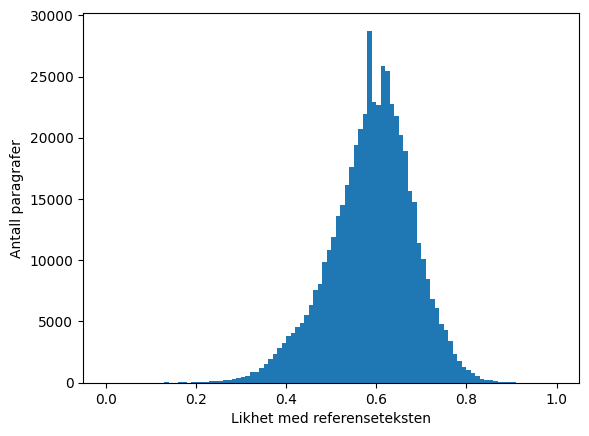

In [75]:
from matplotlib import pyplot as plt

plt.hist(np.concatenate(df["deviation_scaled_with_length"].values), bins=100)
plt.xlabel("Likhet med referenseteksten")
plt.ylabel("Antall paragrafer")
plt.show()

In [76]:
# iterate over the rows in df
target_score = 0.8

num_paras_each_year_year = {}
num_paras_each_year_grant = {}
plot_df = pd.DataFrame(columns=["year", "score", "type"])
for index, row in df.iterrows():
    year = row["concerned_year"]
    typerep = row["type"]
    for score in row["deviation_scaled_with_length"]:
        if typerep == "Årsrapport":
            num_paras_each_year_year[year] = num_paras_each_year_year.get(year, 0) + 1
        elif typerep == "Tildelingsbrev":
            num_paras_each_year_grant[year] = num_paras_each_year_grant.get(year, 0) + 1
        if score > target_score:
            plot_df = pd.concat(
                [
                    plot_df,
                    pd.DataFrame(
                        [[year, score, typerep]], columns=["year", "score", "type"]
                    ),
                ]
            )

/tmp/ipykernel_1337/1202279650.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame(


In [77]:
num_paras_each_year_year

{2020.0: 68801,
 2018.0: 54555,
 2019.0: 61716,
 2017.0: 51243,
 2021.0: 70443,
 2022.0: 122495,
 2023.0: 19106}

In [78]:
num_paras_each_year_grant

{2021.0: 13550,
 2019.0: 13754,
 2020.0: 12255,
 2018.0: 8619,
 2022.0: 12849,
 2023.0: 12751,
 2024.0: 984}

<Axes: title={'center': 'Tildelingsbrev'}, xlabel='year'>

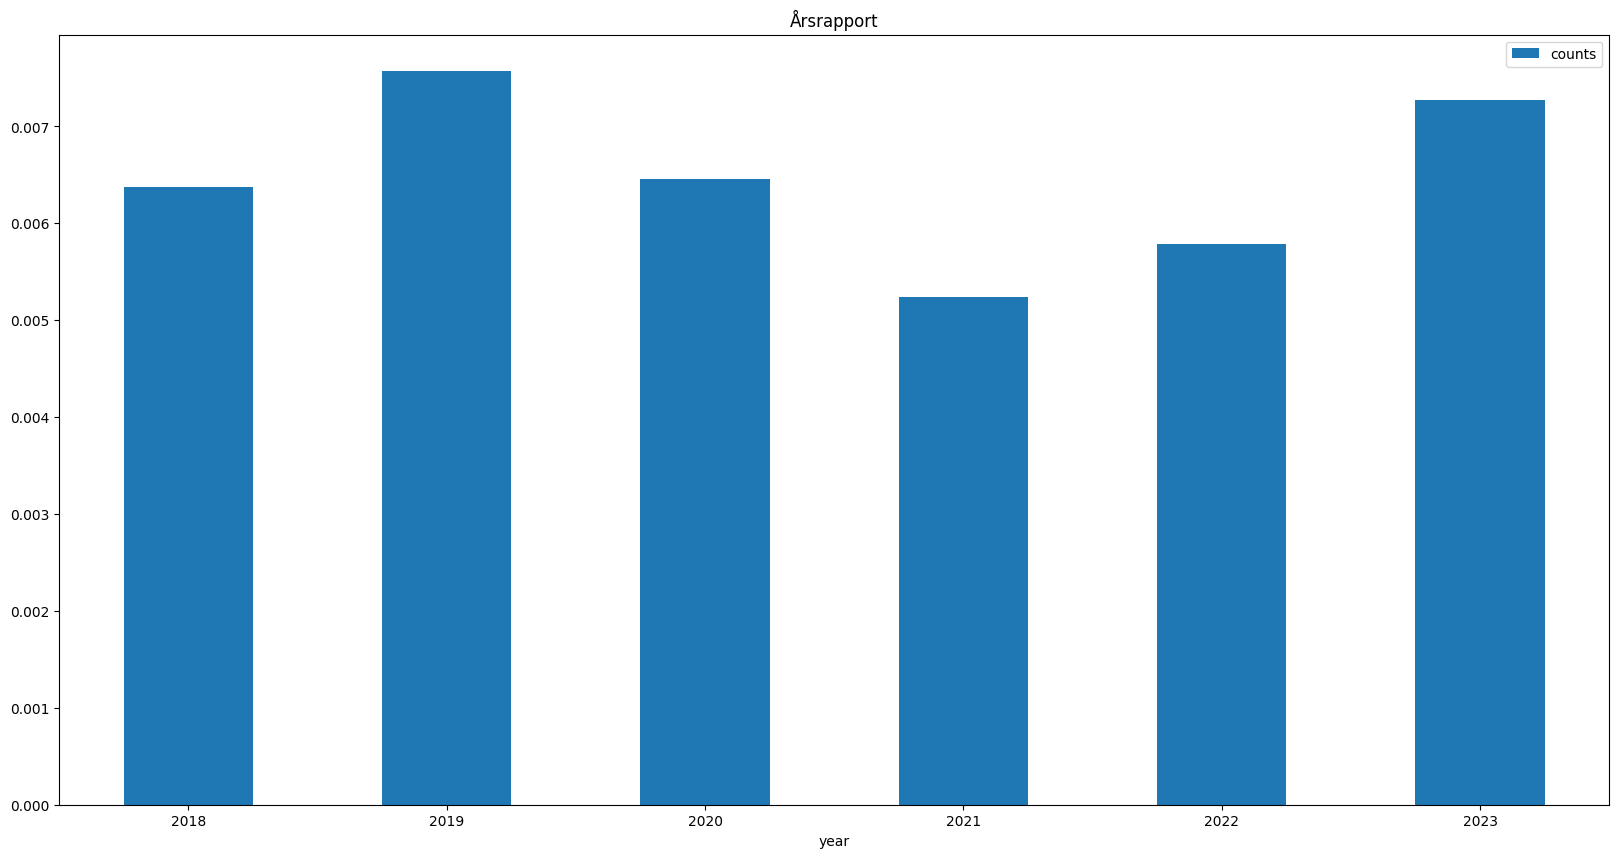

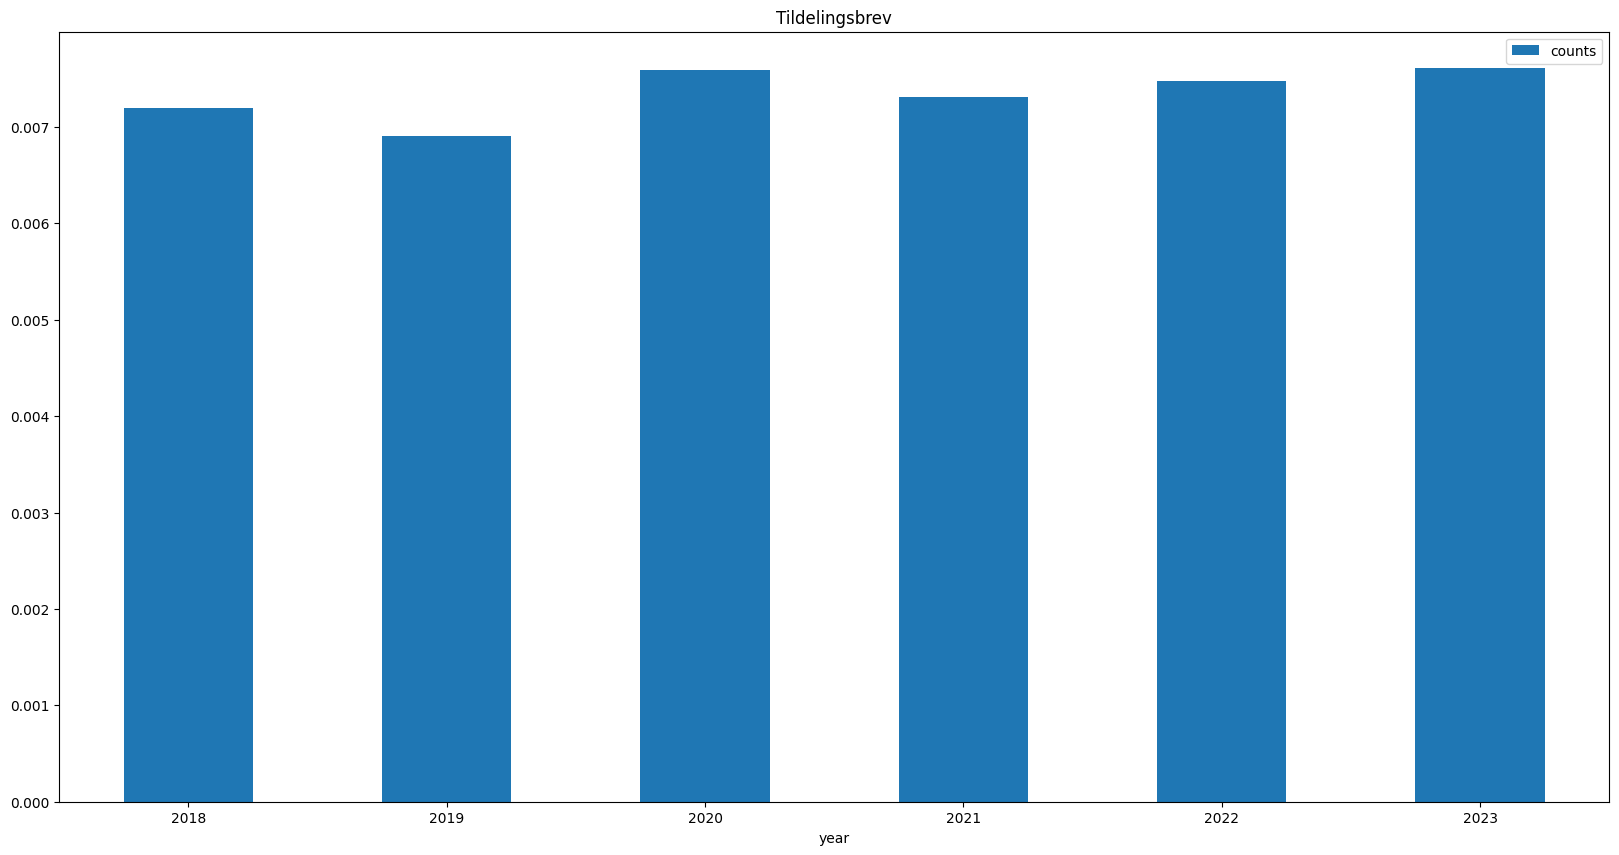

In [79]:
# plot the dataframe with bar charts for each year
# the y axis counts the occurences

plot_df["year"] = plot_df["year"].astype(int)
plot_df = plot_df[~plot_df["year"].isin([2024, 2017])]
plot_df["score"] = plot_df["score"].astype(float)

yearreps = plot_df[plot_df["type"] == "Årsrapport"]
yearreps = yearreps.groupby(["year"]).size().reset_index(name="counts")
yearreps["counts"] = yearreps["counts"] / yearreps["year"].apply(
    lambda x: num_paras_each_year_year[x]
)
yearreps.plot.bar(x="year", y="counts", rot=0, figsize=(20, 10), title="Årsrapport")

grants = plot_df[plot_df["type"] == "Tildelingsbrev"]
grants = grants.groupby(["year"]).size().reset_index(name="counts")
grants["counts"] = grants["counts"] / grants["year"].apply(
    lambda x: num_paras_each_year_grant[x]
)
grants.plot.bar(x="year", y="counts", rot=0, figsize=(20, 10), title="Tildelingsbrev")

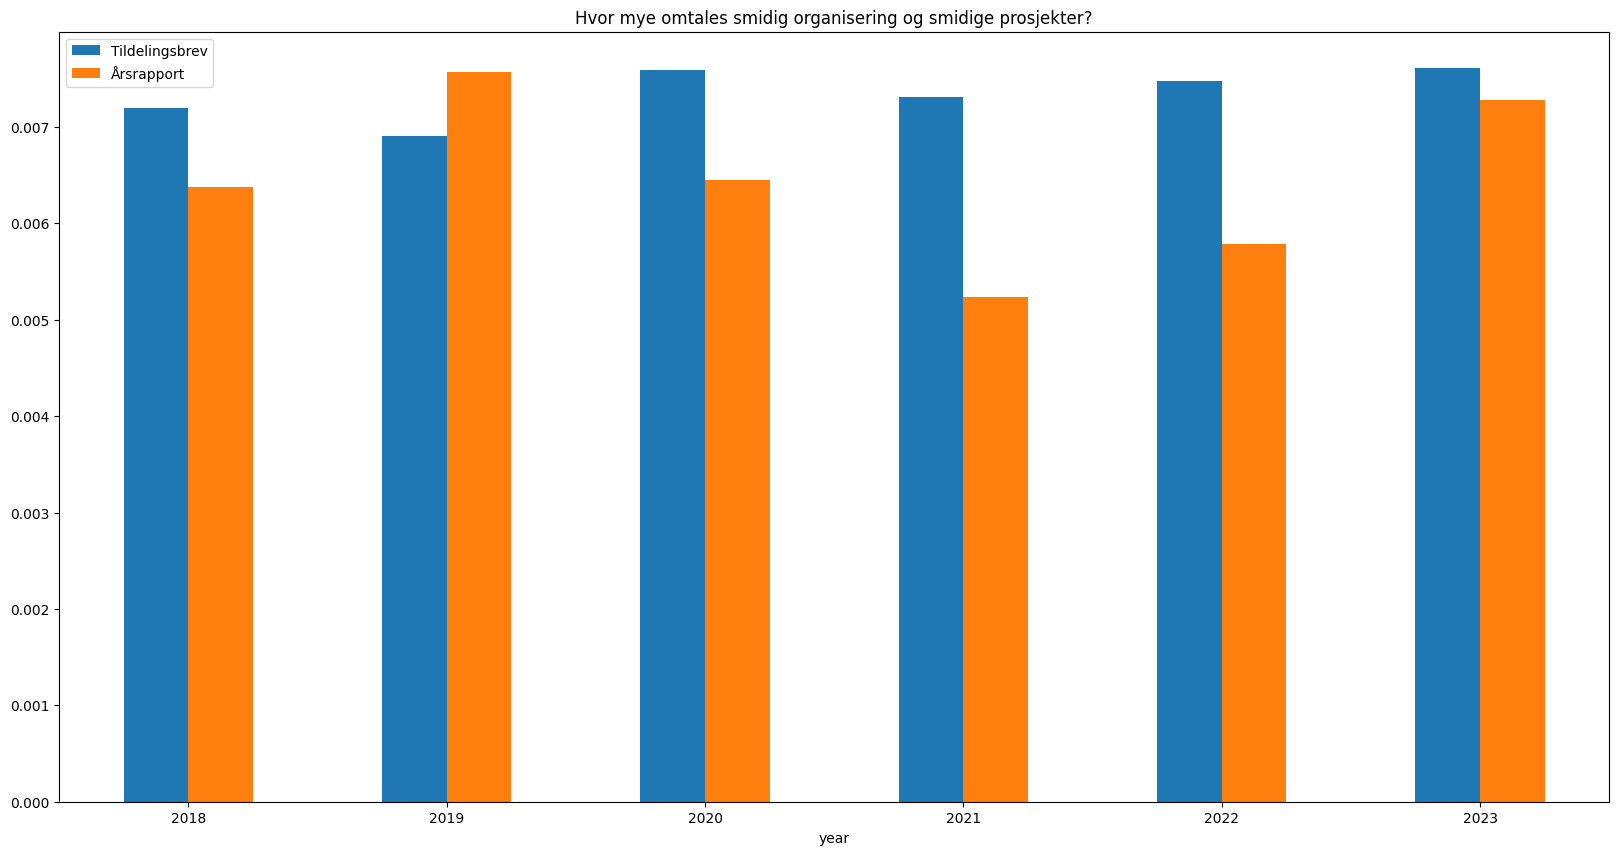

In [83]:
# Create a new DataFrame with yearreps and grants
df = pd.DataFrame(
    {
        "Tildelingsbrev": grants.set_index("year")["counts"],
        "Årsrapport": yearreps.set_index("year")["counts"],
    }
)

# Create a subplot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the DataFrame
df.plot(kind="bar", rot=0, ax=ax)

# Set the title
ax.set_title(f"{question}")

# Show the legend
ax.legend()

# Show the plot
plt.show()